In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from hottbox.utils.generation.basic import residual_tensor
from hottbox.core import Tensor, TensorTKD
from hottbox.algorithms.decomposition import HOSVD, HOOI
from coursework.data import get_image, plot_tensors

In [20]:
np.random.seed(0)

[Return to Table of Contents](./0_Table_of_contents.ipynb)

# Tucker Decomposition

<img src="./imgs/TensorTKD.png" alt="Drawing" style="width: 500px;"/>

In previous [assignment](./2_Efficient_representation_of_multidimensional_arrays.ipynb), you have been provided materials which cover efficient representations of mutlidimensional arrays of data, such as the Tucker form. In this module, you will take a closer look at it and the assiciated computational methods.


Any tensor of arbitrarily large order can be decomposed in the Tucker form. As illustrated above, a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I \times J \times K}$ can be represented as a dense core tensor $\mathbf{\underline{G}}$ and a set of factor matrices $\mathbf{A} \in \mathbb{R}^{I \times Q}, \mathbf{B} \in \mathbb{R}^{J \times R}$ and $\mathbf{C} \in
\mathbb{R}^{K \times P}$

$$
\mathbf{\underline{X}} = \mathbf{\underline{G}} \times_1 \mathbf{A} \times_2 \mathbf{B} \times_3 \mathbf{C} = \Big[    \mathbf{\underline{G}} ;  \mathbf{A},  \mathbf{B}, \mathbf{C}      \Big]
$$


On practice, there exist several computational methods to accomplish this all of which are combined into a Tucker Decomposition framework. The two most commonly used algorithms are:
1. Higher Order Singular Value Decomposition ([HOSVD](#Higher-Order-Singular-Value-Decomposition-(HOSVD)))
1. Higher Order Orthogonal Iteration ([HOOI](#Higher-Order-Orthogonal-Iteration-(HOOI)))


# Higher Order Singular Value Decomposition (HOSVD)

The HOSVD is a special case of the Tucker decomposition, in which all the factor matrices are constrained to be orthogonal. They are computed as truncated version of the left singular matrices of all possible mode-$n$ unfoldings of tensor $\mathbf{\underline{X}}$:

$$
\begin{aligned}
\mathbf{X}_{(1)} &= \mathbf{U}_1  \mathbf{\Sigma}_1 \mathbf{V}_1^T \quad \rightarrow \quad \mathbf{A} = \mathbf{U}_1[1:R_1]\\
\mathbf{X}_{(2)} &= \mathbf{U}_2  \mathbf{\Sigma}_2 \mathbf{V}_2^T \quad \rightarrow \quad \mathbf{B} = \mathbf{U}_2[1:R_2] \\
\mathbf{X}_{(3)} &= \mathbf{U}_3  \mathbf{\Sigma}_3 \mathbf{V}_3^T \quad \rightarrow \quad \mathbf{C} = \mathbf{U}_3[1:R_3] \\
\end{aligned}
$$

After factor matrices are obtained, the core tensor $\mathbf{\underline{G}}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^T \times_2 \mathbf{B}^T \times_3 \mathbf{C}^T        
$$


# Higher Order Orthogonal Iteration (HOOI)

HOOI algorithm is another special case of the Tuker decomposition. Like HOSVD, it decomposes a tensor into a dense core tensor and orthogonal factor matrices. The difference between the two lies in the fact that in HOOI the factor matrices are optimized iteratively using an Alternating Least Squares (ALS) approach. In other words, the tucker representation $[ \mathbf{\underline{G}};\mathbf{A}^{(1)}, \mathbf{A}^{(2)}, \cdots,\mathbf{A}^{(N)} ]$ of the given tensor $\mathbf{\underline{X}}$ is obtained through the HOOI as follows

$$
\begin{aligned}
&\mathbf{\underline{Y}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T} \times_2 \cdots \times_{n-1} \mathbf{A}^{(n-1)T} \times_{n+1} \mathbf{A}^{(n+1)} \times \cdots \times_N \mathbf{A}^{(N)} \\
&\mathbf{A}^{(n)} \leftarrow R_n \text{ leftmost singular vectors of } \mathbf{Y}_{(n)}
\end{aligned}
$$

The above is repeated until convergence, then the core tensor $\mathbf{\underline{G}} \in \mathbb{R}^{R_1 \times R_2 \times \cdots \times R_N}$ is computed as

$$
\mathbf{\underline{G}} = \mathbf{\underline{X}} \times_1 \mathbf{A}^{(1)T}  \times_2 \mathbf{A}^{(2)T} \times_3 \cdots  \times_N \mathbf{A}^{(N)T}
$$

# Multi-linear rank

The **multi-linear rank** of a tensor $\mathbf{\underline{X}} \in \mathbb{R}^{I_1 \times \cdots \times I_N}$ is the $N$-tuple $(R_1, \dots, R_N)$ where each $R_n$ is the rank of the subspace spanned by mode-$n$ fibers, i.e. $R_n = \text{rank} \big( \mathbf{X}_{(n)} \big)$. Thus, for our order-$3$ tensor the multi-linear rank is $(R_1, R_2, R_3)$. Multi-linear rank provides flexibility in compression and approximation of the original tensor.

> **NOTE:** For a tensor of order $N$ the values $R_1, R_2, \dots , R_N$ are not necessarily the same, whereas, for matrices (tensors of order 2) the equality $R_1 = R_2$ always holds, where $R_1$ and $R_2$ are the matrix column rank and row rank respectively.



# Performing tensor decomposition

In [7]:
# Create tensor
I, J, K = 5, 6, 7
array_3d = np.random.rand(I * J * K).reshape((I, J, K)).astype(np.float)
tensor = Tensor(array_3d)

# Initialise algorithm
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 5, 6)
tensor_tkd = algorithm.decompose(tensor, ml_rank)

# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)

Tucker representation of a tensor with multi-linear rank=(4, 5, 6).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (5, 6, 7) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (5, 4)
Mode-1 factor matrix is of shape (6, 5)
Mode-2 factor matrix is of shape (7, 6)

	Core tensor
This tensor is of order 3 and consists of 120 elements.
Sizes and names of its modes are (4, 5, 6) and ['mode-0', 'mode-1', 'mode-2'] respectively.


# Evaluation and reconstruction

Tucker representation of an original tensor is almost always an approximation, regardless of which algorithm has been employed for performing decomposition. Thus, relative error of approximation is commonly used in order to evaluate performance of computational methods, i.e. the ratio between a Frobenious norms of residual and original tensors.

In [8]:
# Compute residual tensor
tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))

Relative error of approximation = 0.21320264561618077


## **Assigment 1**

1. Create a tensor of order 4 with sizes of each mode being defined by prime numbers and  obtain a Tucker representation using HOOI algorithm with multi-linear (4, 10, 6, 2). Then calculation ratio between the number of elements in the original tensor and its Tucker form.

1. For a tensor that consists of 1331 elements, which multi-linear rank guarantees a perfect reconstruction from its Tucker form and why. Is such choice reasonable for practical applications?


### Solution: Part 1

In [21]:
# Create tensor
I, J, K, L, M = 5, 6, 7, 8, 9
array_5d = np.random.rand(I * J * K * L * M).reshape((I, J, K, L, M)).astype(np.float)
tensor = Tensor(array_5d)

In [22]:
# Perform decomposition
# Initialise algorithm
algorithm = HOSVD()

# Perform decomposing for selected multi-linear rank
ml_rank = (4, 5, 6, 7, 8)
tensor_tkd = algorithm.decompose(tensor, ml_rank)

In [24]:
# Print ratio
# Result preview
print(tensor_tkd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd.core)

# Compute residual tensor
tensor_res = residual_tensor(tensor, tensor_tkd)

# Compute error of approximation
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))

Tucker representation of a tensor with multi-linear rank=(4, 5, 6, 7, 8).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2', 'mode-3', 'mode-4']
With corresponding latent components described by (5, 6, 7, 8, 9) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (5, 4)
Mode-1 factor matrix is of shape (6, 5)
Mode-2 factor matrix is of shape (7, 6)
Mode-3 factor matrix is of shape (8, 7)
Mode-4 factor matrix is of shape (9, 8)

	Core tensor
This tensor is of order 5 and consists of 6720 elements.
Sizes and names of its modes are (4, 5, 6, 7, 8) and ['mode-0', 'mode-1', 'mode-2', 'mode-3', 'mode-4'] respectively.
Relative error of approximation = 0.3660243595124533


### Solution: Part 2

The purpose of using the Tucker representation is so that we can perform dimensionality reduction, giving us a more compact representation of the original tensor. This is done so as it normally reduces the computational complexity when performing operations on the tensors. However, for a tensor of 1331 elements, it can only have a multi-linear rank of (11,11,11) in which case its Tucker representation is a perfect reconstruction and provides no reduction in dimensions. Hence it is impractical to perform Tucker decomposition on said tensor.

# Application: Image compression 

Color images can be naturally represented as a tensor of order three with the shape `(height x width x channels)` where channels are, for example, Red, Blue and Green (RGB)

<img src="./imgs/image_to_base_colors.png" alt="Drawing" style="width: 500px;"/>

By keeping its original structure, allows to apply methods from multi-linear analysis. For instance, we can employ algorithms for Tucker decompositions in order to commress oringinal informaiton by varying values of desired multi-linear rank.

```python
# Get data in form of a Tensor
car = get_image(item="car", view="top")
tensor = Tensor(car)

# Initialise algorithm and preform decomposition
algorithm = HOSVD()
tensor_tkd = algorithm.decompose(tensor, rank=(25, 25, 3))

# Evaluate result
tensor_res = residual_tensor(tensor, tensor_tkd)
rel_error = tensor_res.frob_norm / tensor.frob_norm

print("Relative error of approximation = {}".format(rel_error))
```

When can also visually inspect image obtained by reconstructing the Tucker representation
```python
# Reconstruction
tensor_rec = tensor_tkd.reconstruct()

# Plot original and reconstructed images side by side
plot_tensors(tensor, tensor_rec)
```

<img src="./imgs/car_orig_vs_reconstructed_25_25_3.png" alt="Drawing" style="width: 500px;"/>

## **Assigment 2**
For this assignment you are provided with function `get_image()` which requires two parameters: `item` and `view`. The valid values for former are **car** and **apple**, while the latter takes only **side** and **top**. 

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the car and apple. Analyse results by visually inspecting their reconstructions.

1. Use multi-linear rank equal to `(50, 50, 2)` in order to obtain Tucker representations of images of the apple taken from the top and from the side. Analyse results by visually inspecting their reconstructions.

1. What would happen to the reconstruction if the value of multi-linear rank corresponding to the channel mode is decreased to 1.


### Solution: Part 1

In [36]:
# Create tensors from images
car = get_image(item='car', view='top')
apple = get_image(item='apple', view='top')
tensor_car = Tensor(car)
tensor_apple = Tensor(apple)

In [37]:
# Perform decomposition
algorithm = HOSVD()
tensor_tkd_car = algorithm.decompose(tensor_car, rank=(50, 50, 2))
tensor_tkd_apple = algorithm.decompose(tensorA, rank=(50, 50, 2))

Relative error of approximation of car= 0.04991577804571507
Relative error of approximation of apple= 0.037062258387408294


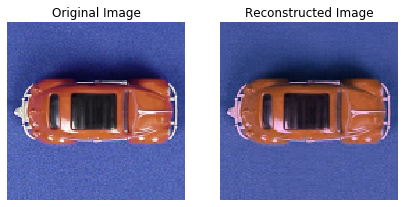

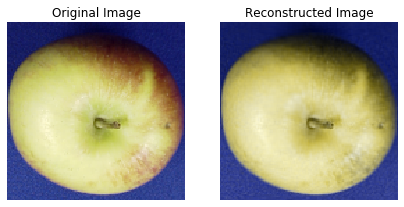

In [38]:
# Evaluate results
tensor_res_car = residual_tensor(tensor_car, tensor_tkd_car)
rel_error_car = tensor_res_car.frob_norm / tensor_car.frob_norm
print("Relative error of approximation of car= {}".format(rel_error_car))
# Reconstruction
tensor_rec_car = tensor_tkd_car.reconstruct()
plot_tensors(tensor_car, tensor_rec_car)

tensor_res_apple = residual_tensor(tensor_apple, tensor_tkd_apple)
rel_error_apple = tensor_res_apple.frob_norm / tensor_apple.frob_norm
print("Relative error of approximation of apple= {}".format(rel_error_apple))
# Reconstruction
tensor_rec_apple = tensor_tkd_apple.reconstruct()
plot_tensors(tensor_apple, tensor_rec_apple)

Though the reconstructed image look very similar to the original image, there are obvious differences between the two images especially in their colour. Instead of using 3 colour channels per the original image, the Tucker representation restricts this to only two channels. This reduction in the degree of freedom is the main cause for the decolourisation of the reconstructed image.

For the car, the differences are less obvious as most of the pixels are either blue or red. Hence two colour channels is sufficient in representing the original image accurately. For the apple however, there is obvious that the red colour in the image is heavily distorted. This is because the representation, with its limited degree of freedom to represent colours, resticted the representation channels to blue and green which make up the predominant number of pixels in the image.

### Solution: Part 2

In [32]:
# Create tensors from images
apple_top = get_image(item='apple', view='top')
apple_side = get_image(item='apple', view='side')
tensor_top = Tensor(apple_top)
tensor_side = Tensor(apple_side)

In [33]:
# Perform decomposition
algorithm = HOSVD()
tensor_tkd_top = algorithm.decompose(tensor_top, rank=(50, 50, 2))
tensor_tkd_side = algorithm.decompose(tensor_side, rank=(50, 50, 2))

Relative error of approximation of apple from top= 0.037062258387408245
Relative error of approximation of apple from side= 0.06574690406026347


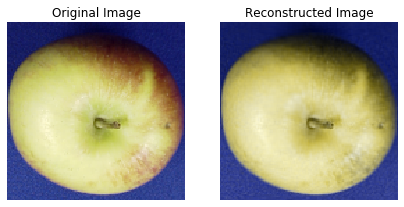

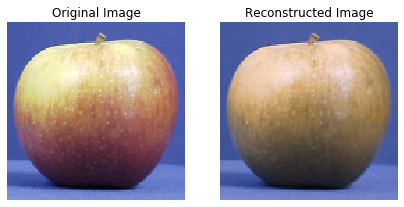

In [34]:
# Evaluate results
tensor_res_top = residual_tensor(tensor_top, tensor_tkd_top)
rel_error_top = tensor_res_top.frob_norm / tensor_top.frob_norm
print("Relative error of approximation of apple from top= {}".format(rel_error_top))
# Reconstruction
tensor_rec_top = tensor_tkd_top.reconstruct()
plot_tensors(tensor_top, tensor_rec_top)

tensor_res_side = residual_tensor(tensor_side, tensor_tkd_side)
rel_error_side = tensor_res_side.frob_norm / tensor_side.frob_norm
print("Relative error of approximation of apple from side= {}".format(rel_error_side))
# Reconstruction
tensor_rec_side = tensor_tkd_side.reconstruct()
plot_tensors(tensor_side, tensor_rec_side)

Again, discolourisation can be seen in both the side view and the top view of the apple due to the reduction in degree of freedom. For the top view, it is the red colour which is heavily affected as the image is predominantly green and blue. For the side view however, since the image is predominantly red and blue, the green colour is the one to be seriously affected. 

### Solution: Part 3

Having only 1 degree of freedom for the colour channels would result in an image of the same colour but of different shades. The colour chosen would be the most dominant colour in the image which in this case is green. From the image below, it is observed that this is true. Intuitively, the colour chosen needs to be the one where the reconstrected image has the minimum relative error of approximation.


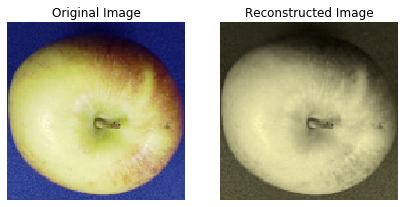

In [31]:
apple = get_image(item='apple', view='top')
tensor = Tensor(apple)

algorithm = HOSVD()
tensor_tkd = algorithm.decompose(tensor, rank=(50, 50, 1))

tensor_rec = tensor_tkd.reconstruct()
plot_tensors(tensor, tensor_rec)